## Preprocess the data and get adjacency matrix 

In [1]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(1, parent_dir+'\Covariance and Adjacency Matrix')
from DataManager import dataManager

name: X_test
shape: (640, 31, 1518)
-----------------------
name: X_train
shape: (640, 31, 1395)
-----------------------
name: clip_sizes_test
shape: (2, 129)
-----------------------
name: clip_sizes_train
shape: (2, 127)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 1518)
-----------------------
name: sel_win_nums_train
shape: (1, 1395)
-----------------------
name: soz_ch_ids
shape: (5, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 1518)
-----------------------
name: y_train
shape: (1, 1395)
-----------------------


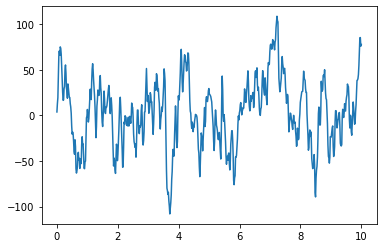

In [2]:
import h5py
import numpy as np
filepath = parent_dir+'\datasets\sample_patients\pat_FR_620.mat'
variables = {}
f = h5py.File(filepath, 'r')
for k, v in f.items():
    variables[k] = np.array(v)
for key in variables.keys():
    print("name:", key)
    print("shape:", variables[key].shape)
    print("-----------------------")
#print sample EGG signal from one node
import matplotlib.pyplot as plt

plt.figure()
ax = plt.axes()
X_train = variables["X_train"]
X_test = variables["X_test"]

ax.plot(np.linspace(0, 10, 640), X_train[:,5,0])

--------data manager successfully initialized--------


C:\Users\caixu\Documents\GitHub\GCNGDE_Simulation_for_EGG_analysis\Covariance and Adjacency Matrix\DataManager.py:140: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.axes()
C:\Users\caixu\Documents\GitHub\GCNGDE_Simulation_for_EGG_analysis\Covariance and Adjacency Matrix\DataManager.py:140: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.axes()
C:\Users\caixu\Documents\GitHub\GCNGDE_Simulation_for_EGG_analysis\C

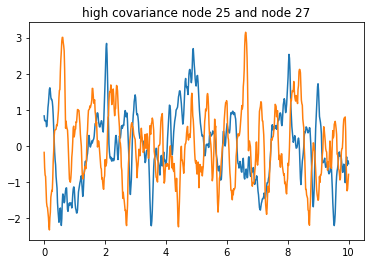

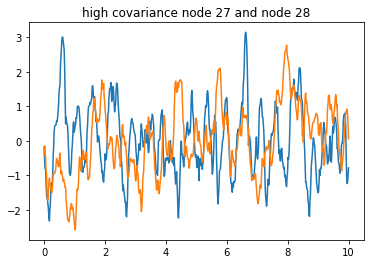

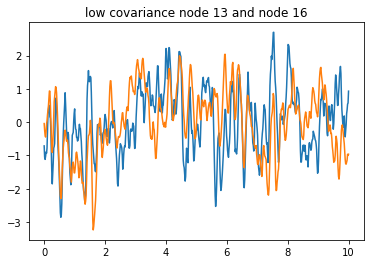

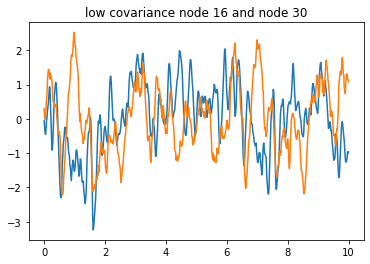

In [3]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))
dm.normalize()
dm.sanity_check(4.514*10**-1, -10**-3, parent_dir)

## create normalized adjacency matrix 

In [4]:
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
def show_heat_map(m):
    plt.imshow(m, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()
    
    
def create_DAD(adj):
    np.fill_diagonal(adj, 1)
    rowsum = np.sum(adj, axis=1)
    d = np.diag_indices(adj.shape[0]) 
    D = np.zeros(adj.shape)
    D[d] = rowsum
    #print(rowsum)
    D = fractional_matrix_power(D, -0.5)
    #print(D)
    return D@adj@D

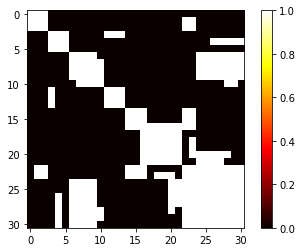

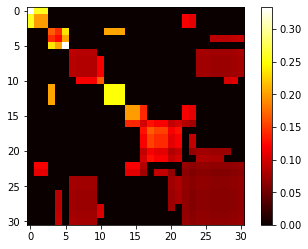

In [5]:
#first fine tune a good threshold n
n = 5*10**-5
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))

## Modified GCN Class

In [6]:
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [7]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=False):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        
        self.reset_parameters()

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ',' \
               + str(self.out_features) + ')'
    
    def reset_parameters(self):
        stdv = 1. / self.weight.size(1) ** 1/2
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)
    
    # H, feature matrix
    # A, precomputed adj matrix
    def forward(self, H, A):
        n = torch.matmul(A, torch.matmul(H, self.weight))
        if self.bias is not None:
            return n + self.bias
        else:
            return n

class SimularityMatrix(nn.Module):
    def __init__(self, in_features):
        super(SimularityMatrix, self).__init__()
        self.in_features = in_features
        
        self.weight = nn.Parameter(torch.Tensor(in_features))
        #self.weight = torch.squeeze(self.weight)
        
        self.reset_parameters()

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) +')'
    
    def reset_parameters(self):
        stdv = 1. / self.weight.size(0) ** 1/2
        self.weight.data.uniform_(-stdv, stdv)
    
    #computes the simularity matrix:
    # H, feature matrix --> N x D
    # A, precomputed adj matrix --> NxN
    # this method is pretty wack, need to find a vectorized way to do it.
    def forward(self, H, H0):
        #get hidden state (concate H0 and H)
        Z = torch.cat((H0, H), 2)
        M = Z.shape[0]
        N = Z.shape[1]
        D = Z.shape[2]
        #centering normalize Z
        Z = self.fcn(Z)
        sim_matrix = torch.zeros(M ,N, N)
        for u in range(N):
            for v in range(N):
                if u>v:
                    zu = torch.reshape(Z[:,u,:], (M,1,D))
                    zv = torch.reshape(Z[:,v,:], (M,1,D))
                    sim_matrix[:,u,v] = self.get_sim(zu, zv)
                    sim_matrix[:,v,u] = sim_matrix[:,u,v]
                elif u==v:    
                    zu = torch.reshape(Z[:,u,:], (M,1,D))
                    a = self.get_sim(zu, zu)
                    #print(a.shape, sim_matrix.shape)
                    sim_matrix[:,u,v] = a
        return sim_matrix
        
    #simularity between node u and node v (shape Mx1xD)
    #return the u,v index of the simularity matrix
    def get_sim(self, u,v):
        theta = torch.diag(self.weight)
        #print(self.weight)
        #print(u.shape, theta.shape, self.weight.shape, torch.transpose(v, 1, 2).shape)
        return torch.squeeze(torch.matmul(torch.matmul(u, theta), torch.transpose(v, 1, 2)))
        
    #centering-normalizing (CN) operator
    def fcn(self, u):
        norm_u = (u - torch.mean(u, dim=2, keepdim=True))
        return norm_u/(((1/(self.in_features-1)) * torch.sum(norm_u**2, dim = 2, keepdim = True))**(1/2))

In [8]:
# n-layer GCN Network
class Net(nn.Module):
    def __init__(self, body_features, n_layers, activation = F.relu, bias=False):
        super(Net, self).__init__()
        assert(n_layers >= 1)
        self.activation = activation
        self.head = GCN(body_features, body_features, bias)
        self.layers = nn.ModuleList()
        for i in range(n_layers - 1):
            self.layers.append(GCN(body_features, body_features, bias))
        self.tail = SimularityMatrix(body_features*2) # size(H_0 + h_u)

    def forward(self, h_0, A):
        x = self.activation(self.head(h_0, A))
        for layer in self.layers:
            x = self.activation(layer(x, A))
        sim_matrix = self.tail(x, h_0)
        return sim_matrix

In [9]:
class sim_loss(torch.nn.Module):

    def __init__(self):
        super(sim_loss,self).__init__()

    def forward(self, sim_matrix, A, epsilon = 1e-8):
        A_tf = (A!=0)
        M = sim_matrix.shape[0]
        abs_N = torch.sum(A_tf, dim = 1, keepdim = True)
        logexp_S = torch.log(torch.sum(torch.exp(sim_matrix), dim = 2, keepdim = True)+epsilon)
        obj_matrix = A_tf*(sim_matrix - abs_N * logexp_S)
        return -(1/M)*torch.sum(obj_matrix)

In [14]:
A = torch.from_numpy(create_DAD(dm.A_train)).float()
X_train = torch.from_numpy(dm.X_train).float()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
parameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'n_layers': 2,
    'num_epochs': 1000,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
print(parameters)

{'body': 640, 'M': 1387, 'batch_size': 128, 'n_layers': 2, 'num_epochs': 1000, 'learning_rate': 0.001, 'weight_decay': 0.005}


In [15]:
A = A.to(device)
model = Net(parameters['body'], parameters['n_layers'], F.relu, bias=True).to(device)
input_features = X_train.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], weight_decay=parameters['weight_decay'])
criterion = sim_loss()

In [16]:
torch.cuda.empty_cache()
from torchsummary import summary
print(model)
summary(model, [(31,640), (31,31)])

Net(
  (head): GCN (640,640)
  (layers): ModuleList(
    (0): GCN (640,640)
  )
  (tail): SimularityMatrix (1280)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GCN-1              [-1, 31, 640]         410,240
               GCN-2              [-1, 31, 640]         410,240
  SimularityMatrix-3               [-1, 31, 31]           1,280
Total params: 821,760
Trainable params: 821,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 72.73
Forward/backward pass size (MB): 0.31
Params size (MB): 3.13
Estimated Total Size (MB): 76.18
----------------------------------------------------------------


In [17]:
n_epochs = parameters['num_epochs']
batch_size = parameters['batch_size']
from tqdm import tqdm
for epoch in range(1, n_epochs+1):

    # X is a torch Variable
    permutation = torch.randperm(input_features.shape[0])

    for i in tqdm(range(0,input_features.shape[0], batch_size)):
        model.train()
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size] if i+batch_size < input_features.shape[0] else permutation[i:] 
        batch_x= input_features[indices, :,:]

        sim_matrix = model(batch_x, A).to(device)
        train_loss = criterion(sim_matrix, A)
        train_loss.backward()
        optimizer.step()
        print("Epoch:", epoch, "  Batch:", int((i/batch_size)+1),"of size",batch_size, "  Train loss:", train_loss, end="\r")
    print()
'''
for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    sim_matrix = model(input_features, A)
    train_loss = criterion(sim_matrix, A)
    train_loss.backward()
    optimizer.step()
    print("{}: \ttrain loss {}".format(epoch, train_loss))
'''

  9%|▉         | 1/11 [00:00<00:07,  1.31it/s]

 18%|█▊        | 2/11 [00:01<00:06,  1.37it/s]

 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.46it/s]

 45%|████▌     | 5/11 [00:03<00:04,  1.49it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.50it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1   Batch: 11 of size 128   Train loss: tensor(11915.3311, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 2   Batch: 11 of size 128   Train loss: tensor(6326.8818, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 3   Batch: 11 of size 128   Train loss: tensor(-30530.3633, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 4   Batch: 11 of size 128   Train loss: tensor(-49323.3438, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 5   Batch: 11 of size 128   Train loss: tensor(-51472.3516, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.47it/s]

 18%|█▊        | 2/11 [00:01<00:06,  1.49it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 6   Batch: 11 of size 128   Train loss: tensor(-53748.8203, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 7   Batch: 11 of size 128   Train loss: tensor(-55441.1484, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 8   Batch: 11 of size 128   Train loss: tensor(-55671.8828, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 9   Batch: 11 of size 128   Train loss: tensor(-55894.3828, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 10   Batch: 11 of size 128   Train loss: tensor(-55851.8828, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.58it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.58it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.57it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.57it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 11   Batch: 11 of size 128   Train loss: tensor(-56082.2656, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.57it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.58it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.57it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 12   Batch: 11 of size 128   Train loss: tensor(-56154.1953, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 13   Batch: 11 of size 128   Train loss: tensor(-56066.6836, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 14   Batch: 11 of size 128   Train loss: tensor(-56169.4453, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.51it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.47it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 15   Batch: 11 of size 128   Train loss: tensor(-56110.9609, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 16   Batch: 11 of size 128   Train loss: tensor(-56182.3711, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.57it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 17   Batch: 11 of size 128   Train loss: tensor(-56201.1992, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 18   Batch: 11 of size 128   Train loss: tensor(-56194.3594, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.57it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 19   Batch: 11 of size 128   Train loss: tensor(-56215.6250, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.57it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:02<00:05,  1.50it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 20   Batch: 11 of size 128   Train loss: tensor(-56182.3828, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.59it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.57it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.57it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 21   Batch: 11 of size 128   Train loss: tensor(-56190.1289, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.50it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 22   Batch: 11 of size 128   Train loss: tensor(-56211.9805, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 23   Batch: 11 of size 128   Train loss: tensor(-56182.3359, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.51it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 24   Batch: 11 of size 128   Train loss: tensor(-56223.7070, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.49it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 25   Batch: 11 of size 128   Train loss: tensor(-56197.7617, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 26   Batch: 11 of size 128   Train loss: tensor(-56213.6523, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.58it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 27   Batch: 11 of size 128   Train loss: tensor(-56223.8398, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.49it/s]

 18%|█▊        | 2/11 [00:01<00:06,  1.50it/s]

 27%|██▋       | 3/11 [00:02<00:05,  1.49it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.51it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 28   Batch: 11 of size 128   Train loss: tensor(-56218.7539, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.51it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 29   Batch: 11 of size 128   Train loss: tensor(-56219.3164, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 30   Batch: 11 of size 128   Train loss: tensor(-56212.3828, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 31   Batch: 11 of size 128   Train loss: tensor(-56220.4336, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 32   Batch: 11 of size 128   Train loss: tensor(-56222.8047, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.57it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.57it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.57it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.57it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 33   Batch: 11 of size 128   Train loss: tensor(-56228.4844, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.57it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.57it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 34   Batch: 11 of size 128   Train loss: tensor(-56218.6328, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.58it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.58it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.57it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.57it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.57it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 35   Batch: 11 of size 128   Train loss: tensor(-56236.5586, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 36   Batch: 11 of size 128   Train loss: tensor(-56229.0039, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 37   Batch: 11 of size 128   Train loss: tensor(-56228.4062, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 38   Batch: 11 of size 128   Train loss: tensor(-56230.9062, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 39   Batch: 11 of size 128   Train loss: tensor(-56237.8359, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 40   Batch: 11 of size 128   Train loss: tensor(-56229.6133, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 41   Batch: 11 of size 128   Train loss: tensor(-56232.2773, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.57it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 42   Batch: 11 of size 128   Train loss: tensor(-56226.5000, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 43   Batch: 11 of size 128   Train loss: tensor(-56236.7773, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 44   Batch: 11 of size 128   Train loss: tensor(-56235.2734, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 45   Batch: 11 of size 128   Train loss: tensor(-56233.5977, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 46   Batch: 11 of size 128   Train loss: tensor(-56237.9531, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 47   Batch: 11 of size 128   Train loss: tensor(-56236.6445, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 48   Batch: 11 of size 128   Train loss: tensor(-56232.6914, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 49   Batch: 11 of size 128   Train loss: tensor(-56248.0352, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 50   Batch: 11 of size 128   Train loss: tensor(-56241.2227, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 51   Batch: 11 of size 128   Train loss: tensor(-56241.5820, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 52   Batch: 11 of size 128   Train loss: tensor(-56240.2070, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.57it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 53   Batch: 11 of size 128   Train loss: tensor(-56239.8008, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 54   Batch: 11 of size 128   Train loss: tensor(-56241.2695, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 55   Batch: 11 of size 128   Train loss: tensor(-56243.0391, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 56   Batch: 11 of size 128   Train loss: tensor(-56234.5859, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 57   Batch: 11 of size 128   Train loss: tensor(-56242.7734, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 58   Batch: 11 of size 128   Train loss: tensor(-56243.7266, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 59   Batch: 11 of size 128   Train loss: tensor(-56236.1953, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 60   Batch: 11 of size 128   Train loss: tensor(-56242.0117, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 61   Batch: 11 of size 128   Train loss: tensor(-56241.0078, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 62   Batch: 11 of size 128   Train loss: tensor(-56244.2773, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 63   Batch: 11 of size 128   Train loss: tensor(-56243.3828, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 64   Batch: 11 of size 128   Train loss: tensor(-56244.2148, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 65   Batch: 11 of size 128   Train loss: tensor(-56249.4453, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 66   Batch: 11 of size 128   Train loss: tensor(-56229.0742, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 67   Batch: 11 of size 128   Train loss: tensor(-56245.7969, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 68   Batch: 11 of size 128   Train loss: tensor(-56243.3203, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 69   Batch: 11 of size 128   Train loss: tensor(-56249.1523, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 70   Batch: 11 of size 128   Train loss: tensor(-56239.5352, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 71   Batch: 11 of size 128   Train loss: tensor(-56240.5352, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 72   Batch: 11 of size 128   Train loss: tensor(-56244.6133, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 73   Batch: 11 of size 128   Train loss: tensor(-56247.5391, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 74   Batch: 11 of size 128   Train loss: tensor(-56247.5039, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 75   Batch: 11 of size 128   Train loss: tensor(-56248.0625, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.50it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 76   Batch: 11 of size 128   Train loss: tensor(-56243.6094, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.58it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 77   Batch: 11 of size 128   Train loss: tensor(-56251.8398, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 78   Batch: 11 of size 128   Train loss: tensor(-56248.9570, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 79   Batch: 11 of size 128   Train loss: tensor(-56244.9805, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 80   Batch: 11 of size 128   Train loss: tensor(-56246.5977, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 81   Batch: 11 of size 128   Train loss: tensor(-56242.1562, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 82   Batch: 11 of size 128   Train loss: tensor(-56243.9922, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 83   Batch: 11 of size 128   Train loss: tensor(-56244.4297, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 84   Batch: 11 of size 128   Train loss: tensor(-56251.7617, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 85   Batch: 11 of size 128   Train loss: tensor(-56249.2305, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.57it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 86   Batch: 11 of size 128   Train loss: tensor(-56248.9531, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 87   Batch: 11 of size 128   Train loss: tensor(-56245.3164, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 88   Batch: 11 of size 128   Train loss: tensor(-56254.5117, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 89   Batch: 11 of size 128   Train loss: tensor(-56246.9414, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 90   Batch: 11 of size 128   Train loss: tensor(-56247.6445, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 91   Batch: 11 of size 128   Train loss: tensor(-56251.5312, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 92   Batch: 11 of size 128   Train loss: tensor(-56249.0312, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 93   Batch: 11 of size 128   Train loss: tensor(-56252.5664, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 94   Batch: 11 of size 128   Train loss: tensor(-56256.1016, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 95   Batch: 11 of size 128   Train loss: tensor(-56250.5859, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 96   Batch: 11 of size 128   Train loss: tensor(-56249.1328, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 97   Batch: 11 of size 128   Train loss: tensor(-56256.0273, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 98   Batch: 11 of size 128   Train loss: tensor(-56255.1719, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 99   Batch: 11 of size 128   Train loss: tensor(-56254.6836, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 100   Batch: 11 of size 128   Train loss: tensor(-56252.2148, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 101   Batch: 11 of size 128   Train loss: tensor(-56261.9219, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 102   Batch: 11 of size 128   Train loss: tensor(-56253.6953, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 103   Batch: 11 of size 128   Train loss: tensor(-56252.6797, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 104   Batch: 11 of size 128   Train loss: tensor(-56253.2773, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 105   Batch: 11 of size 128   Train loss: tensor(-56254.3359, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 106   Batch: 11 of size 128   Train loss: tensor(-56258.2852, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 107   Batch: 11 of size 128   Train loss: tensor(-56260.3867, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 108   Batch: 11 of size 128   Train loss: tensor(-56255.7266, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 109   Batch: 11 of size 128   Train loss: tensor(-56260.7148, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 110   Batch: 11 of size 128   Train loss: tensor(-56254.5469, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 111   Batch: 11 of size 128   Train loss: tensor(-56258.3164, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 112   Batch: 11 of size 128   Train loss: tensor(-56260.5586, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 113   Batch: 11 of size 128   Train loss: tensor(-56259.7852, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 114   Batch: 11 of size 128   Train loss: tensor(-56260.5078, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 115   Batch: 11 of size 128   Train loss: tensor(-56266.5273, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 116   Batch: 11 of size 128   Train loss: tensor(-56266.3828, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 117   Batch: 11 of size 128   Train loss: tensor(-56268.0781, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 118   Batch: 11 of size 128   Train loss: tensor(-56263.9766, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 119   Batch: 11 of size 128   Train loss: tensor(-56266.8008, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 120   Batch: 11 of size 128   Train loss: tensor(-56265.2539, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 121   Batch: 11 of size 128   Train loss: tensor(-56268.1797, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 122   Batch: 11 of size 128   Train loss: tensor(-56267.2500, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 123   Batch: 11 of size 128   Train loss: tensor(-56268.8945, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 124   Batch: 11 of size 128   Train loss: tensor(-56269.2539, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 125   Batch: 11 of size 128   Train loss: tensor(-56267.2422, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 126   Batch: 11 of size 128   Train loss: tensor(-56269.0820, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 127   Batch: 11 of size 128   Train loss: tensor(-56264.7461, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 128   Batch: 11 of size 128   Train loss: tensor(-56266.7930, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 129   Batch: 11 of size 128   Train loss: tensor(-56273.2266, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 130   Batch: 11 of size 128   Train loss: tensor(-56273.2617, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 131   Batch: 11 of size 128   Train loss: tensor(-56269.5977, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 132   Batch: 11 of size 128   Train loss: tensor(-56273.5820, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 133   Batch: 11 of size 128   Train loss: tensor(-56279.1367, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 134   Batch: 11 of size 128   Train loss: tensor(-56272.8203, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 135   Batch: 11 of size 128   Train loss: tensor(-56269.7031, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 136   Batch: 11 of size 128   Train loss: tensor(-56274.1836, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 137   Batch: 11 of size 128   Train loss: tensor(-56270.1328, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 138   Batch: 11 of size 128   Train loss: tensor(-56277.9219, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 139   Batch: 11 of size 128   Train loss: tensor(-56276.0117, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 140   Batch: 11 of size 128   Train loss: tensor(-56280.7266, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 141   Batch: 11 of size 128   Train loss: tensor(-56280.0742, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 142   Batch: 11 of size 128   Train loss: tensor(-56281.1953, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 143   Batch: 11 of size 128   Train loss: tensor(-56284.3359, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 144   Batch: 11 of size 128   Train loss: tensor(-56285.5781, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 145   Batch: 11 of size 128   Train loss: tensor(-56284.1328, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 146   Batch: 11 of size 128   Train loss: tensor(-56280.6016, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 147   Batch: 11 of size 128   Train loss: tensor(-56284.8281, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 148   Batch: 11 of size 128   Train loss: tensor(-56282.6289, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 149   Batch: 11 of size 128   Train loss: tensor(-56288.2891, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 150   Batch: 11 of size 128   Train loss: tensor(-56281.4219, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 151   Batch: 11 of size 128   Train loss: tensor(-56279.7930, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 152   Batch: 11 of size 128   Train loss: tensor(-56280.3047, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.57it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 153   Batch: 11 of size 128   Train loss: tensor(-56281.3711, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 154   Batch: 11 of size 128   Train loss: tensor(-56290.7852, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 155   Batch: 11 of size 128   Train loss: tensor(-56282.4648, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 156   Batch: 11 of size 128   Train loss: tensor(-56290.3672, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 157   Batch: 11 of size 128   Train loss: tensor(-56291.5859, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 158   Batch: 11 of size 128   Train loss: tensor(-56291.4805, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 159   Batch: 11 of size 128   Train loss: tensor(-56293.2227, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 160   Batch: 11 of size 128   Train loss: tensor(-56295.5234, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 161   Batch: 11 of size 128   Train loss: tensor(-56291.6992, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 162   Batch: 11 of size 128   Train loss: tensor(-56288.6953, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 163   Batch: 11 of size 128   Train loss: tensor(-56291.0273, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 164   Batch: 11 of size 128   Train loss: tensor(-56293.6055, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 165   Batch: 11 of size 128   Train loss: tensor(-56289.8633, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 166   Batch: 11 of size 128   Train loss: tensor(-56286.6133, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 167   Batch: 11 of size 128   Train loss: tensor(-56295.0820, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 168   Batch: 11 of size 128   Train loss: tensor(-56293.4922, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.57it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 169   Batch: 11 of size 128   Train loss: tensor(-56295.9414, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 170   Batch: 11 of size 128   Train loss: tensor(-56294.2070, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.57it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 171   Batch: 11 of size 128   Train loss: tensor(-56295.7305, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 172   Batch: 11 of size 128   Train loss: tensor(-56295.3828, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 173   Batch: 11 of size 128   Train loss: tensor(-56296.0391, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 174   Batch: 11 of size 128   Train loss: tensor(-56298.7734, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 175   Batch: 11 of size 128   Train loss: tensor(-56300.2305, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 176   Batch: 11 of size 128   Train loss: tensor(-56295.9375, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 177   Batch: 11 of size 128   Train loss: tensor(-56297.2695, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 178   Batch: 11 of size 128   Train loss: tensor(-56304.7695, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 179   Batch: 11 of size 128   Train loss: tensor(-56298.5977, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.57it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 180   Batch: 11 of size 128   Train loss: tensor(-56301.1016, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 181   Batch: 11 of size 128   Train loss: tensor(-56303.2969, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 182   Batch: 11 of size 128   Train loss: tensor(-56302.7695, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 183   Batch: 11 of size 128   Train loss: tensor(-56297.1992, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 184   Batch: 11 of size 128   Train loss: tensor(-56300.9570, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 185   Batch: 11 of size 128   Train loss: tensor(-56303.8398, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 186   Batch: 11 of size 128   Train loss: tensor(-56305.6719, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 187   Batch: 11 of size 128   Train loss: tensor(-56306.3633, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 188   Batch: 11 of size 128   Train loss: tensor(-56302.7734, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 189   Batch: 11 of size 128   Train loss: tensor(-56306.2773, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 190   Batch: 11 of size 128   Train loss: tensor(-56297.4922, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 191   Batch: 11 of size 128   Train loss: tensor(-56301.5117, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 192   Batch: 11 of size 128   Train loss: tensor(-56305.6992, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 193   Batch: 11 of size 128   Train loss: tensor(-56307.8125, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 194   Batch: 11 of size 128   Train loss: tensor(-56303.9062, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 195   Batch: 11 of size 128   Train loss: tensor(-56307.9805, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 196   Batch: 11 of size 128   Train loss: tensor(-56312.8477, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 197   Batch: 11 of size 128   Train loss: tensor(-56308.6445, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 198   Batch: 11 of size 128   Train loss: tensor(-56312.0547, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 199   Batch: 11 of size 128   Train loss: tensor(-56308.3047, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 200   Batch: 11 of size 128   Train loss: tensor(-56305.9805, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 201   Batch: 11 of size 128   Train loss: tensor(-56311.2227, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 202   Batch: 11 of size 128   Train loss: tensor(-56311.6523, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 203   Batch: 11 of size 128   Train loss: tensor(-56308.8750, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 204   Batch: 11 of size 128   Train loss: tensor(-56315.0312, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 205   Batch: 11 of size 128   Train loss: tensor(-56313.1250, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 206   Batch: 11 of size 128   Train loss: tensor(-56319.4883, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 207   Batch: 11 of size 128   Train loss: tensor(-56313.4844, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 208   Batch: 11 of size 128   Train loss: tensor(-56312.2617, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 209   Batch: 11 of size 128   Train loss: tensor(-56318.9883, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 210   Batch: 11 of size 128   Train loss: tensor(-56309.7461, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 211   Batch: 11 of size 128   Train loss: tensor(-56313.8359, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 212   Batch: 11 of size 128   Train loss: tensor(-56319.7930, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 213   Batch: 11 of size 128   Train loss: tensor(-56319.0586, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 214   Batch: 11 of size 128   Train loss: tensor(-56316.3984, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 215   Batch: 11 of size 128   Train loss: tensor(-56316.9688, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 216   Batch: 11 of size 128   Train loss: tensor(-56321.3398, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 217   Batch: 11 of size 128   Train loss: tensor(-56319.9219, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 218   Batch: 11 of size 128   Train loss: tensor(-56319.3711, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 219   Batch: 11 of size 128   Train loss: tensor(-56318.8125, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 220   Batch: 11 of size 128   Train loss: tensor(-56322.4922, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.57it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.57it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 221   Batch: 11 of size 128   Train loss: tensor(-56317.3633, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 222   Batch: 11 of size 128   Train loss: tensor(-56320.5742, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 223   Batch: 11 of size 128   Train loss: tensor(-56314.8750, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 224   Batch: 11 of size 128   Train loss: tensor(-56323.2695, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 225   Batch: 11 of size 128   Train loss: tensor(-56328.9805, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 226   Batch: 11 of size 128   Train loss: tensor(-56323.1758, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 227   Batch: 11 of size 128   Train loss: tensor(-56326.0078, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 228   Batch: 11 of size 128   Train loss: tensor(-56323.9453, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 229   Batch: 11 of size 128   Train loss: tensor(-56330.0352, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 230   Batch: 11 of size 128   Train loss: tensor(-56325.4609, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 231   Batch: 11 of size 128   Train loss: tensor(-56330.0898, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 232   Batch: 11 of size 128   Train loss: tensor(-56329.6914, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 233   Batch: 11 of size 128   Train loss: tensor(-56329.2305, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 234   Batch: 11 of size 128   Train loss: tensor(-56325.0742, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 235   Batch: 11 of size 128   Train loss: tensor(-56331.8477, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 236   Batch: 11 of size 128   Train loss: tensor(-56327.5039, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 237   Batch: 11 of size 128   Train loss: tensor(-56334.0586, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 238   Batch: 11 of size 128   Train loss: tensor(-56342.2383, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 239   Batch: 11 of size 128   Train loss: tensor(-56335.2148, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 240   Batch: 11 of size 128   Train loss: tensor(-56333.7773, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 241   Batch: 11 of size 128   Train loss: tensor(-56330.4570, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 242   Batch: 11 of size 128   Train loss: tensor(-56336.7852, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 243   Batch: 11 of size 128   Train loss: tensor(-56334.0742, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 244   Batch: 11 of size 128   Train loss: tensor(-56333.2227, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 245   Batch: 11 of size 128   Train loss: tensor(-56334.3438, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 246   Batch: 11 of size 128   Train loss: tensor(-56332.3359, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 247   Batch: 11 of size 128   Train loss: tensor(-56335.9609, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 248   Batch: 11 of size 128   Train loss: tensor(-56338.9062, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 249   Batch: 11 of size 128   Train loss: tensor(-56337.5742, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 250   Batch: 11 of size 128   Train loss: tensor(-56337.5469, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 251   Batch: 11 of size 128   Train loss: tensor(-56339.5547, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 252   Batch: 11 of size 128   Train loss: tensor(-56335.7852, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 253   Batch: 11 of size 128   Train loss: tensor(-56337.3711, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 254   Batch: 11 of size 128   Train loss: tensor(-56337.0352, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 255   Batch: 11 of size 128   Train loss: tensor(-56341.1953, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 256   Batch: 11 of size 128   Train loss: tensor(-56346.5000, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 257   Batch: 11 of size 128   Train loss: tensor(-56342.0039, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 258   Batch: 11 of size 128   Train loss: tensor(-56342.8594, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 259   Batch: 11 of size 128   Train loss: tensor(-56336.8125, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 260   Batch: 11 of size 128   Train loss: tensor(-56342.3008, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 261   Batch: 11 of size 128   Train loss: tensor(-56343.4453, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 262   Batch: 11 of size 128   Train loss: tensor(-56349.7773, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 263   Batch: 11 of size 128   Train loss: tensor(-56349.6094, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 264   Batch: 11 of size 128   Train loss: tensor(-56343.3438, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 265   Batch: 11 of size 128   Train loss: tensor(-56344.2422, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.49it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 266   Batch: 11 of size 128   Train loss: tensor(-56345.5820, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 267   Batch: 11 of size 128   Train loss: tensor(-56344.1211, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 268   Batch: 11 of size 128   Train loss: tensor(-56352.3164, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 269   Batch: 11 of size 128   Train loss: tensor(-56349.0781, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 270   Batch: 11 of size 128   Train loss: tensor(-56349.7930, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 271   Batch: 11 of size 128   Train loss: tensor(-56346.0547, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 272   Batch: 11 of size 128   Train loss: tensor(-56351.9375, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 273   Batch: 11 of size 128   Train loss: tensor(-56349.5508, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 274   Batch: 11 of size 128   Train loss: tensor(-56352.8867, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 275   Batch: 11 of size 128   Train loss: tensor(-56351.2305, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 276   Batch: 11 of size 128   Train loss: tensor(-56352.4844, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 277   Batch: 11 of size 128   Train loss: tensor(-56351.8125, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 278   Batch: 11 of size 128   Train loss: tensor(-56352.2695, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 279   Batch: 11 of size 128   Train loss: tensor(-56355.3281, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 280   Batch: 11 of size 128   Train loss: tensor(-56355.4883, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 281   Batch: 11 of size 128   Train loss: tensor(-56351.0547, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 282   Batch: 11 of size 128   Train loss: tensor(-56352.5312, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 283   Batch: 11 of size 128   Train loss: tensor(-56357.1719, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 284   Batch: 11 of size 128   Train loss: tensor(-56358.7383, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 285   Batch: 11 of size 128   Train loss: tensor(-56360.0156, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 286   Batch: 11 of size 128   Train loss: tensor(-56359.3281, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 287   Batch: 11 of size 128   Train loss: tensor(-56361.3438, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 288   Batch: 11 of size 128   Train loss: tensor(-56361.8906, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 289   Batch: 11 of size 128   Train loss: tensor(-56361.1289, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 290   Batch: 11 of size 128   Train loss: tensor(-56357.9844, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 291   Batch: 11 of size 128   Train loss: tensor(-56363.9844, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 292   Batch: 11 of size 128   Train loss: tensor(-56359.2695, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 293   Batch: 11 of size 128   Train loss: tensor(-56363.2695, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.57it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 294   Batch: 11 of size 128   Train loss: tensor(-56362.1953, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 295   Batch: 11 of size 128   Train loss: tensor(-56359.6133, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 296   Batch: 11 of size 128   Train loss: tensor(-56361.6719, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 297   Batch: 11 of size 128   Train loss: tensor(-56360.7930, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 298   Batch: 11 of size 128   Train loss: tensor(-56363.0039, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 299   Batch: 11 of size 128   Train loss: tensor(-56363.2891, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 300   Batch: 11 of size 128   Train loss: tensor(-56362.5117, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 301   Batch: 11 of size 128   Train loss: tensor(-56365.8164, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 302   Batch: 11 of size 128   Train loss: tensor(-56366.2227, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 303   Batch: 11 of size 128   Train loss: tensor(-56365.0352, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 304   Batch: 11 of size 128   Train loss: tensor(-56364.8828, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 305   Batch: 11 of size 128   Train loss: tensor(-56368.6250, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 306   Batch: 11 of size 128   Train loss: tensor(-56370.7383, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 307   Batch: 11 of size 128   Train loss: tensor(-56368.1758, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 308   Batch: 11 of size 128   Train loss: tensor(-56364.9531, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 309   Batch: 11 of size 128   Train loss: tensor(-56368.9141, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 310   Batch: 11 of size 128   Train loss: tensor(-56365.6992, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 311   Batch: 11 of size 128   Train loss: tensor(-56368.8594, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 312   Batch: 11 of size 128   Train loss: tensor(-56366.2656, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 313   Batch: 11 of size 128   Train loss: tensor(-56369.6055, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 314   Batch: 11 of size 128   Train loss: tensor(-56368.0508, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 315   Batch: 11 of size 128   Train loss: tensor(-56371.6328, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 316   Batch: 11 of size 128   Train loss: tensor(-56372.1367, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 317   Batch: 11 of size 128   Train loss: tensor(-56371.8828, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 318   Batch: 11 of size 128   Train loss: tensor(-56367.0352, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 319   Batch: 11 of size 128   Train loss: tensor(-56372.4570, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 320   Batch: 11 of size 128   Train loss: tensor(-56375.0312, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 321   Batch: 11 of size 128   Train loss: tensor(-56373.5391, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 322   Batch: 11 of size 128   Train loss: tensor(-56371.9844, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 323   Batch: 11 of size 128   Train loss: tensor(-56378.9336, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 324   Batch: 11 of size 128   Train loss: tensor(-56375.0273, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 325   Batch: 11 of size 128   Train loss: tensor(-56370.9180, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 326   Batch: 11 of size 128   Train loss: tensor(-56374.9375, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 327   Batch: 11 of size 128   Train loss: tensor(-56372.6445, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 328   Batch: 11 of size 128   Train loss: tensor(-56373.6094, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 329   Batch: 11 of size 128   Train loss: tensor(-56379.2227, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 330   Batch: 11 of size 128   Train loss: tensor(-56376.1484, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 331   Batch: 11 of size 128   Train loss: tensor(-56377.8477, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 332   Batch: 11 of size 128   Train loss: tensor(-56377.3906, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 333   Batch: 11 of size 128   Train loss: tensor(-56375.9219, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 334   Batch: 11 of size 128   Train loss: tensor(-56377.4062, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 335   Batch: 11 of size 128   Train loss: tensor(-56375.4922, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 336   Batch: 11 of size 128   Train loss: tensor(-56381.1680, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 337   Batch: 11 of size 128   Train loss: tensor(-56375.3672, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 338   Batch: 11 of size 128   Train loss: tensor(-56373.3164, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 339   Batch: 11 of size 128   Train loss: tensor(-56377.9805, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 340   Batch: 11 of size 128   Train loss: tensor(-56380.4375, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 341   Batch: 11 of size 128   Train loss: tensor(-56378.6719, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 342   Batch: 11 of size 128   Train loss: tensor(-56377.2227, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 343   Batch: 11 of size 128   Train loss: tensor(-56381.1250, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 344   Batch: 11 of size 128   Train loss: tensor(-56379.3359, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 345   Batch: 11 of size 128   Train loss: tensor(-56380.0273, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 346   Batch: 11 of size 128   Train loss: tensor(-56382.4375, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.49it/s]

 18%|█▊        | 2/11 [00:01<00:06,  1.50it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 347   Batch: 11 of size 128   Train loss: tensor(-56383.2930, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.47it/s]

 18%|█▊        | 2/11 [00:01<00:06,  1.49it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.50it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.49it/s]

 45%|████▌     | 5/11 [00:03<00:04,  1.50it/s]

 55%|█████▍    | 6/11 [00:04<00:03,  1.49it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 348   Batch: 11 of size 128   Train loss: tensor(-56381.5820, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 349   Batch: 11 of size 128   Train loss: tensor(-56378.4688, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 350   Batch: 11 of size 128   Train loss: tensor(-56382.0547, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 351   Batch: 11 of size 128   Train loss: tensor(-56381.9570, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 352   Batch: 11 of size 128   Train loss: tensor(-56378.1328, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 353   Batch: 11 of size 128   Train loss: tensor(-56379.2383, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 354   Batch: 11 of size 128   Train loss: tensor(-56382.0352, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 355   Batch: 11 of size 128   Train loss: tensor(-56382.8008, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 356   Batch: 11 of size 128   Train loss: tensor(-56384.0586, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 357   Batch: 11 of size 128   Train loss: tensor(-56382.9844, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 358   Batch: 11 of size 128   Train loss: tensor(-56384.3867, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 359   Batch: 11 of size 128   Train loss: tensor(-56387.2852, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 360   Batch: 11 of size 128   Train loss: tensor(-56379.8125, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 361   Batch: 11 of size 128   Train loss: tensor(-56388.1953, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 362   Batch: 11 of size 128   Train loss: tensor(-56385.2031, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 363   Batch: 11 of size 128   Train loss: tensor(-56384.3398, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 364   Batch: 11 of size 128   Train loss: tensor(-56381.9219, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 365   Batch: 11 of size 128   Train loss: tensor(-56384.2227, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 366   Batch: 11 of size 128   Train loss: tensor(-56381.5859, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 367   Batch: 11 of size 128   Train loss: tensor(-56386.3438, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 368   Batch: 11 of size 128   Train loss: tensor(-56387.3359, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 369   Batch: 11 of size 128   Train loss: tensor(-56386.0469, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 370   Batch: 11 of size 128   Train loss: tensor(-56387.6328, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 371   Batch: 11 of size 128   Train loss: tensor(-56387.8750, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.57it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 372   Batch: 11 of size 128   Train loss: tensor(-56386.3438, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 373   Batch: 11 of size 128   Train loss: tensor(-56387.6797, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 374   Batch: 11 of size 128   Train loss: tensor(-56385.4297, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 375   Batch: 11 of size 128   Train loss: tensor(-56386.8398, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 376   Batch: 11 of size 128   Train loss: tensor(-56386.8711, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 377   Batch: 11 of size 128   Train loss: tensor(-56385.1914, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 378   Batch: 11 of size 128   Train loss: tensor(-56388.4922, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 379   Batch: 11 of size 128   Train loss: tensor(-56387.0547, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 380   Batch: 11 of size 128   Train loss: tensor(-56385.9688, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 381   Batch: 11 of size 128   Train loss: tensor(-56387.7188, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 382   Batch: 11 of size 128   Train loss: tensor(-56389.8945, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 383   Batch: 11 of size 128   Train loss: tensor(-56388.8945, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 384   Batch: 11 of size 128   Train loss: tensor(-56388.0391, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 385   Batch: 11 of size 128   Train loss: tensor(-56388.8203, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 386   Batch: 11 of size 128   Train loss: tensor(-56392.7695, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 387   Batch: 11 of size 128   Train loss: tensor(-56392.5391, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 388   Batch: 11 of size 128   Train loss: tensor(-56393.2227, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 389   Batch: 11 of size 128   Train loss: tensor(-56392.0391, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 390   Batch: 11 of size 128   Train loss: tensor(-56389.6250, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 391   Batch: 11 of size 128   Train loss: tensor(-56391.8750, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 392   Batch: 11 of size 128   Train loss: tensor(-56393.5391, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 393   Batch: 11 of size 128   Train loss: tensor(-56393.5469, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 394   Batch: 11 of size 128   Train loss: tensor(-56389.7031, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 395   Batch: 11 of size 128   Train loss: tensor(-56385.2695, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 396   Batch: 11 of size 128   Train loss: tensor(-56390.8125, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 397   Batch: 11 of size 128   Train loss: tensor(-56392.5273, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 398   Batch: 11 of size 128   Train loss: tensor(-56390.5508, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 399   Batch: 11 of size 128   Train loss: tensor(-56393.8164, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 400   Batch: 11 of size 128   Train loss: tensor(-56393.8398, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 401   Batch: 11 of size 128   Train loss: tensor(-56392.7031, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 402   Batch: 11 of size 128   Train loss: tensor(-56392.6094, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 403   Batch: 11 of size 128   Train loss: tensor(-56393.1719, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 404   Batch: 11 of size 128   Train loss: tensor(-56391.8672, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 405   Batch: 11 of size 128   Train loss: tensor(-56395.1367, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 406   Batch: 11 of size 128   Train loss: tensor(-56394.2969, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 407   Batch: 11 of size 128   Train loss: tensor(-56393.2500, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 408   Batch: 11 of size 128   Train loss: tensor(-56396.1484, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 409   Batch: 11 of size 128   Train loss: tensor(-56390.3359, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 410   Batch: 11 of size 128   Train loss: tensor(-56395.1992, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 411   Batch: 11 of size 128   Train loss: tensor(-56398.3828, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 412   Batch: 11 of size 128   Train loss: tensor(-56398.4922, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 413   Batch: 11 of size 128   Train loss: tensor(-56394.0312, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 414   Batch: 11 of size 128   Train loss: tensor(-56393.5391, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.57it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 415   Batch: 11 of size 128   Train loss: tensor(-56393.7383, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 416   Batch: 11 of size 128   Train loss: tensor(-56395.2305, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 417   Batch: 11 of size 128   Train loss: tensor(-56400.4648, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 418   Batch: 11 of size 128   Train loss: tensor(-56394.6914, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 419   Batch: 11 of size 128   Train loss: tensor(-56395.8672, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 420   Batch: 11 of size 128   Train loss: tensor(-56394.7617, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 421   Batch: 11 of size 128   Train loss: tensor(-56399.6055, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 422   Batch: 11 of size 128   Train loss: tensor(-56394.1016, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 423   Batch: 11 of size 128   Train loss: tensor(-56395.7930, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 424   Batch: 11 of size 128   Train loss: tensor(-56396.7383, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 425   Batch: 11 of size 128   Train loss: tensor(-56396.4766, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 426   Batch: 11 of size 128   Train loss: tensor(-56401.8945, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 427   Batch: 11 of size 128   Train loss: tensor(-56398.7734, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 428   Batch: 11 of size 128   Train loss: tensor(-56398.2227, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 429   Batch: 11 of size 128   Train loss: tensor(-56397.5391, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 430   Batch: 11 of size 128   Train loss: tensor(-56397.1367, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 431   Batch: 11 of size 128   Train loss: tensor(-56399.0273, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 432   Batch: 11 of size 128   Train loss: tensor(-56402.8945, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 433   Batch: 11 of size 128   Train loss: tensor(-56400.6289, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 434   Batch: 11 of size 128   Train loss: tensor(-56396.0273, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 435   Batch: 11 of size 128   Train loss: tensor(-56395.8594, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 436   Batch: 11 of size 128   Train loss: tensor(-56398.2852, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 437   Batch: 11 of size 128   Train loss: tensor(-56401.9219, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 438   Batch: 11 of size 128   Train loss: tensor(-56401.1289, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 439   Batch: 11 of size 128   Train loss: tensor(-56399.6953, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 440   Batch: 11 of size 128   Train loss: tensor(-56396.1758, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 441   Batch: 11 of size 128   Train loss: tensor(-56400.3711, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 442   Batch: 11 of size 128   Train loss: tensor(-56403.2773, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 443   Batch: 11 of size 128   Train loss: tensor(-56400.4297, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.57it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.57it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 444   Batch: 11 of size 128   Train loss: tensor(-56405.6328, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 445   Batch: 11 of size 128   Train loss: tensor(-56403.8047, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 446   Batch: 11 of size 128   Train loss: tensor(-56402.4883, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 447   Batch: 11 of size 128   Train loss: tensor(-56403.4336, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 448   Batch: 11 of size 128   Train loss: tensor(-56401.4844, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 449   Batch: 11 of size 128   Train loss: tensor(-56403.7852, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 450   Batch: 11 of size 128   Train loss: tensor(-56401.2656, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 451   Batch: 11 of size 128   Train loss: tensor(-56402.3867, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 452   Batch: 11 of size 128   Train loss: tensor(-56402.8008, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 453   Batch: 11 of size 128   Train loss: tensor(-56406.3164, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 454   Batch: 11 of size 128   Train loss: tensor(-56403.4648, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 455   Batch: 11 of size 128   Train loss: tensor(-56402.4531, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 456   Batch: 11 of size 128   Train loss: tensor(-56405.6133, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 457   Batch: 11 of size 128   Train loss: tensor(-56401.2383, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 458   Batch: 11 of size 128   Train loss: tensor(-56405.1289, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.49it/s]

 18%|█▊        | 2/11 [00:01<00:06,  1.50it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 459   Batch: 11 of size 128   Train loss: tensor(-56405.8750, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 460   Batch: 11 of size 128   Train loss: tensor(-56403.5156, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 461   Batch: 11 of size 128   Train loss: tensor(-56408.0977, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 462   Batch: 11 of size 128   Train loss: tensor(-56408.2773, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 463   Batch: 11 of size 128   Train loss: tensor(-56407.7188, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 464   Batch: 11 of size 128   Train loss: tensor(-56405.7383, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 465   Batch: 11 of size 128   Train loss: tensor(-56405.1758, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 466   Batch: 11 of size 128   Train loss: tensor(-56410.3984, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 467   Batch: 11 of size 128   Train loss: tensor(-56407.9609, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 468   Batch: 11 of size 128   Train loss: tensor(-56406.0078, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 469   Batch: 11 of size 128   Train loss: tensor(-56407.0469, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 470   Batch: 11 of size 128   Train loss: tensor(-56408.5234, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 471   Batch: 11 of size 128   Train loss: tensor(-56407.3281, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 472   Batch: 11 of size 128   Train loss: tensor(-56406.7930, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 473   Batch: 11 of size 128   Train loss: tensor(-56407.8398, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 474   Batch: 11 of size 128   Train loss: tensor(-56411.3594, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 475   Batch: 11 of size 128   Train loss: tensor(-56409.2422, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 476   Batch: 11 of size 128   Train loss: tensor(-56409.5312, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 477   Batch: 11 of size 128   Train loss: tensor(-56409.9219, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 478   Batch: 11 of size 128   Train loss: tensor(-56410.9219, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 479   Batch: 11 of size 128   Train loss: tensor(-56406.2617, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 480   Batch: 11 of size 128   Train loss: tensor(-56409.8242, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 481   Batch: 11 of size 128   Train loss: tensor(-56413.3438, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 482   Batch: 11 of size 128   Train loss: tensor(-56410.0625, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 483   Batch: 11 of size 128   Train loss: tensor(-56414.5039, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 484   Batch: 11 of size 128   Train loss: tensor(-56410.9219, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 485   Batch: 11 of size 128   Train loss: tensor(-56412.7148, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 486   Batch: 11 of size 128   Train loss: tensor(-56411.2266, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 487   Batch: 11 of size 128   Train loss: tensor(-56405.8672, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 488   Batch: 11 of size 128   Train loss: tensor(-56412.8164, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 489   Batch: 11 of size 128   Train loss: tensor(-56414.1094, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 490   Batch: 11 of size 128   Train loss: tensor(-56409.9609, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 491   Batch: 11 of size 128   Train loss: tensor(-56412.1016, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 492   Batch: 11 of size 128   Train loss: tensor(-56413.4102, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.49it/s]

 18%|█▊        | 2/11 [00:01<00:06,  1.49it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 493   Batch: 11 of size 128   Train loss: tensor(-56417.0156, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 494   Batch: 11 of size 128   Train loss: tensor(-56411.4414, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 495   Batch: 11 of size 128   Train loss: tensor(-56413.8945, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:06,  1.50it/s]

 27%|██▋       | 3/11 [00:02<00:05,  1.50it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 496   Batch: 11 of size 128   Train loss: tensor(-56414.3633, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 497   Batch: 11 of size 128   Train loss: tensor(-56417.9844, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 498   Batch: 11 of size 128   Train loss: tensor(-56411.8281, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 499   Batch: 11 of size 128   Train loss: tensor(-56415.5898, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 500   Batch: 11 of size 128   Train loss: tensor(-56411.0898, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 501   Batch: 11 of size 128   Train loss: tensor(-56411.3125, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 502   Batch: 11 of size 128   Train loss: tensor(-56414.5859, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 503   Batch: 11 of size 128   Train loss: tensor(-56415.7461, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 504   Batch: 11 of size 128   Train loss: tensor(-56412.5977, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 505   Batch: 11 of size 128   Train loss: tensor(-56414.0742, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 506   Batch: 11 of size 128   Train loss: tensor(-56416.7930, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 507   Batch: 11 of size 128   Train loss: tensor(-56417.3359, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 508   Batch: 11 of size 128   Train loss: tensor(-56412.9180, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.49it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.49it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 509   Batch: 11 of size 128   Train loss: tensor(-56416.2734, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:06,  1.50it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 510   Batch: 11 of size 128   Train loss: tensor(-56415.2188, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 511   Batch: 11 of size 128   Train loss: tensor(-56414.8477, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 512   Batch: 11 of size 128   Train loss: tensor(-56417.5586, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 513   Batch: 11 of size 128   Train loss: tensor(-56415.5664, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 514   Batch: 11 of size 128   Train loss: tensor(-56414.7070, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 515   Batch: 11 of size 128   Train loss: tensor(-56414.7930, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 516   Batch: 11 of size 128   Train loss: tensor(-56418.2148, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.56it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 517   Batch: 11 of size 128   Train loss: tensor(-56415.4297, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 518   Batch: 11 of size 128   Train loss: tensor(-56419.1562, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 519   Batch: 11 of size 128   Train loss: tensor(-56418.6914, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 520   Batch: 11 of size 128   Train loss: tensor(-56417.9922, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 521   Batch: 11 of size 128   Train loss: tensor(-56419., device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 522   Batch: 11 of size 128   Train loss: tensor(-56415.4531, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 523   Batch: 11 of size 128   Train loss: tensor(-56416.2695, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 524   Batch: 11 of size 128   Train loss: tensor(-56418.5117, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 525   Batch: 11 of size 128   Train loss: tensor(-56416.7031, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 526   Batch: 11 of size 128   Train loss: tensor(-56417.1094, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.48it/s]

 18%|█▊        | 2/11 [00:01<00:06,  1.50it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 527   Batch: 11 of size 128   Train loss: tensor(-56418.4648, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 528   Batch: 11 of size 128   Train loss: tensor(-56419.4375, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 529   Batch: 11 of size 128   Train loss: tensor(-56422.0508, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 530   Batch: 11 of size 128   Train loss: tensor(-56422.4062, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 531   Batch: 11 of size 128   Train loss: tensor(-56416.0898, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 532   Batch: 11 of size 128   Train loss: tensor(-56422.7969, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 533   Batch: 11 of size 128   Train loss: tensor(-56416.8594, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 534   Batch: 11 of size 128   Train loss: tensor(-56417.7461, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 535   Batch: 11 of size 128   Train loss: tensor(-56419.1797, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 536   Batch: 11 of size 128   Train loss: tensor(-56418.0977, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 537   Batch: 11 of size 128   Train loss: tensor(-56423.1133, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 538   Batch: 11 of size 128   Train loss: tensor(-56421.4180, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 539   Batch: 11 of size 128   Train loss: tensor(-56422.0039, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 540   Batch: 11 of size 128   Train loss: tensor(-56421.7734, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:07,  1.43it/s]

 18%|█▊        | 2/11 [00:01<00:06,  1.46it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.49it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 541   Batch: 11 of size 128   Train loss: tensor(-56424.2070, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 542   Batch: 11 of size 128   Train loss: tensor(-56418.6094, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 543   Batch: 11 of size 128   Train loss: tensor(-56423.1289, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 544   Batch: 11 of size 128   Train loss: tensor(-56420.0898, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 545   Batch: 11 of size 128   Train loss: tensor(-56422.5586, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 546   Batch: 11 of size 128   Train loss: tensor(-56423.3711, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 547   Batch: 11 of size 128   Train loss: tensor(-56425.1289, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 548   Batch: 11 of size 128   Train loss: tensor(-56425.3438, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 549   Batch: 11 of size 128   Train loss: tensor(-56422.3828, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 550   Batch: 11 of size 128   Train loss: tensor(-56422.1797, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 551   Batch: 11 of size 128   Train loss: tensor(-56424.4648, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 552   Batch: 11 of size 128   Train loss: tensor(-56421.6562, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 553   Batch: 11 of size 128   Train loss: tensor(-56421.8984, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 554   Batch: 11 of size 128   Train loss: tensor(-56424.3398, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 555   Batch: 11 of size 128   Train loss: tensor(-56423.2031, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 556   Batch: 11 of size 128   Train loss: tensor(-56424.3828, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 557   Batch: 11 of size 128   Train loss: tensor(-56425.2461, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 558   Batch: 11 of size 128   Train loss: tensor(-56421.4375, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 559   Batch: 11 of size 128   Train loss: tensor(-56427.4766, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 560   Batch: 11 of size 128   Train loss: tensor(-56424.7461, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 561   Batch: 11 of size 128   Train loss: tensor(-56424.9805, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 562   Batch: 11 of size 128   Train loss: tensor(-56424.3047, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 563   Batch: 11 of size 128   Train loss: tensor(-56425.7383, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 564   Batch: 11 of size 128   Train loss: tensor(-56424.5586, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 565   Batch: 11 of size 128   Train loss: tensor(-56427.8008, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 566   Batch: 11 of size 128   Train loss: tensor(-56425.3516, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 567   Batch: 11 of size 128   Train loss: tensor(-56427.2500, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 568   Batch: 11 of size 128   Train loss: tensor(-56422.9180, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 569   Batch: 11 of size 128   Train loss: tensor(-56429.0820, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 570   Batch: 11 of size 128   Train loss: tensor(-56426.6133, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 571   Batch: 11 of size 128   Train loss: tensor(-56427.5781, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.50it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 572   Batch: 11 of size 128   Train loss: tensor(-56426.1953, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 573   Batch: 11 of size 128   Train loss: tensor(-56428.5820, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 574   Batch: 11 of size 128   Train loss: tensor(-56428.3281, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 575   Batch: 11 of size 128   Train loss: tensor(-56429.6484, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 576   Batch: 11 of size 128   Train loss: tensor(-56428.9297, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 577   Batch: 11 of size 128   Train loss: tensor(-56427.8867, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 578   Batch: 11 of size 128   Train loss: tensor(-56427.8906, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 579   Batch: 11 of size 128   Train loss: tensor(-56427.2188, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 580   Batch: 11 of size 128   Train loss: tensor(-56425.1680, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 581   Batch: 11 of size 128   Train loss: tensor(-56429.4180, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 582   Batch: 11 of size 128   Train loss: tensor(-56422.6992, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 583   Batch: 11 of size 128   Train loss: tensor(-56424.2383, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 584   Batch: 11 of size 128   Train loss: tensor(-56420.0469, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 585   Batch: 11 of size 128   Train loss: tensor(-56426.3516, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 586   Batch: 11 of size 128   Train loss: tensor(-56425.4844, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 587   Batch: 11 of size 128   Train loss: tensor(-56429.8477, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 588   Batch: 11 of size 128   Train loss: tensor(-56429.0859, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 589   Batch: 11 of size 128   Train loss: tensor(-56424.7695, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 590   Batch: 11 of size 128   Train loss: tensor(-56428.6133, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 591   Batch: 11 of size 128   Train loss: tensor(-56428.4062, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 592   Batch: 11 of size 128   Train loss: tensor(-56433.0117, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 593   Batch: 11 of size 128   Train loss: tensor(-56430.3125, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 594   Batch: 11 of size 128   Train loss: tensor(-56431.9141, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 595   Batch: 11 of size 128   Train loss: tensor(-56430.9883, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 596   Batch: 11 of size 128   Train loss: tensor(-56431.1211, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.49it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 597   Batch: 11 of size 128   Train loss: tensor(-56434.0391, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 598   Batch: 11 of size 128   Train loss: tensor(-56434.2305, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 599   Batch: 11 of size 128   Train loss: tensor(-56433.0820, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 600   Batch: 11 of size 128   Train loss: tensor(-56434.9883, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 601   Batch: 11 of size 128   Train loss: tensor(-56430.3711, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 602   Batch: 11 of size 128   Train loss: tensor(-56429.4453, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 603   Batch: 11 of size 128   Train loss: tensor(-56432.9336, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 604   Batch: 11 of size 128   Train loss: tensor(-56431.4180, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 605   Batch: 11 of size 128   Train loss: tensor(-56434.3203, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 606   Batch: 11 of size 128   Train loss: tensor(-56429.9609, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 607   Batch: 11 of size 128   Train loss: tensor(-56435.3438, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 608   Batch: 11 of size 128   Train loss: tensor(-56420.7930, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 609   Batch: 11 of size 128   Train loss: tensor(-56432.1055, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 610   Batch: 11 of size 128   Train loss: tensor(-56434.3203, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 611   Batch: 11 of size 128   Train loss: tensor(-56433.5508, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 612   Batch: 11 of size 128   Train loss: tensor(-56431.6992, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 613   Batch: 11 of size 128   Train loss: tensor(-56432.9141, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 614   Batch: 11 of size 128   Train loss: tensor(-56434.4648, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 615   Batch: 11 of size 128   Train loss: tensor(-56432.9805, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 616   Batch: 11 of size 128   Train loss: tensor(-56432.4375, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 617   Batch: 11 of size 128   Train loss: tensor(-56433.9688, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 618   Batch: 11 of size 128   Train loss: tensor(-56433.6094, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 619   Batch: 11 of size 128   Train loss: tensor(-56433.1289, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 620   Batch: 11 of size 128   Train loss: tensor(-56432.6562, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 621   Batch: 11 of size 128   Train loss: tensor(-56436.8164, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 622   Batch: 11 of size 128   Train loss: tensor(-56433.9648, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 623   Batch: 11 of size 128   Train loss: tensor(-56438.1836, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 624   Batch: 11 of size 128   Train loss: tensor(-56434.1953, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 625   Batch: 11 of size 128   Train loss: tensor(-56437.8164, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 626   Batch: 11 of size 128   Train loss: tensor(-56435.7461, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 627   Batch: 11 of size 128   Train loss: tensor(-56435.1094, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 628   Batch: 11 of size 128   Train loss: tensor(-56438.1680, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 629   Batch: 11 of size 128   Train loss: tensor(-56436.0820, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 630   Batch: 11 of size 128   Train loss: tensor(-56436.7188, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.49it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 631   Batch: 11 of size 128   Train loss: tensor(-56436.1992, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 632   Batch: 11 of size 128   Train loss: tensor(-56438.6445, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 633   Batch: 11 of size 128   Train loss: tensor(-56437.7617, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 634   Batch: 11 of size 128   Train loss: tensor(-56436.2773, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 635   Batch: 11 of size 128   Train loss: tensor(-56435.7930, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 636   Batch: 11 of size 128   Train loss: tensor(-56437.4766, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 637   Batch: 11 of size 128   Train loss: tensor(-56434.1836, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 638   Batch: 11 of size 128   Train loss: tensor(-56437.7930, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 639   Batch: 11 of size 128   Train loss: tensor(-56437.6250, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.49it/s]

 18%|█▊        | 2/11 [00:01<00:06,  1.50it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 640   Batch: 11 of size 128   Train loss: tensor(-56440.3672, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 641   Batch: 11 of size 128   Train loss: tensor(-56437.4297, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 642   Batch: 11 of size 128   Train loss: tensor(-56437.3438, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 643   Batch: 11 of size 128   Train loss: tensor(-56435.7695, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 644   Batch: 11 of size 128   Train loss: tensor(-56436.7227, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 645   Batch: 11 of size 128   Train loss: tensor(-56435.3711, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 646   Batch: 11 of size 128   Train loss: tensor(-56434.9766, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 647   Batch: 11 of size 128   Train loss: tensor(-56437.3711, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 648   Batch: 11 of size 128   Train loss: tensor(-56440.6719, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 649   Batch: 11 of size 128   Train loss: tensor(-56433.3438, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 650   Batch: 11 of size 128   Train loss: tensor(-56439., device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 651   Batch: 11 of size 128   Train loss: tensor(-56436.0312, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 652   Batch: 11 of size 128   Train loss: tensor(-56438.1836, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 653   Batch: 11 of size 128   Train loss: tensor(-56437.4141, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 654   Batch: 11 of size 128   Train loss: tensor(-56440.8945, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 655   Batch: 11 of size 128   Train loss: tensor(-56439.6094, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 656   Batch: 11 of size 128   Train loss: tensor(-56439.7617, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 657   Batch: 11 of size 128   Train loss: tensor(-56442.2305, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 658   Batch: 11 of size 128   Train loss: tensor(-56436.5391, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 659   Batch: 11 of size 128   Train loss: tensor(-56440.6992, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 660   Batch: 11 of size 128   Train loss: tensor(-56443.7188, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 661   Batch: 11 of size 128   Train loss: tensor(-56442.2422, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 662   Batch: 11 of size 128   Train loss: tensor(-56439.2188, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 663   Batch: 11 of size 128   Train loss: tensor(-56438.7734, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 664   Batch: 11 of size 128   Train loss: tensor(-56439.9688, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 665   Batch: 11 of size 128   Train loss: tensor(-56436.4180, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 666   Batch: 11 of size 128   Train loss: tensor(-56439.3008, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 667   Batch: 11 of size 128   Train loss: tensor(-56439.5312, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 668   Batch: 11 of size 128   Train loss: tensor(-56440.1719, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 669   Batch: 11 of size 128   Train loss: tensor(-56439.6758, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 670   Batch: 11 of size 128   Train loss: tensor(-56441.2773, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 671   Batch: 11 of size 128   Train loss: tensor(-56439.3945, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 672   Batch: 11 of size 128   Train loss: tensor(-56442.4141, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 673   Batch: 11 of size 128   Train loss: tensor(-56442.6016, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 674   Batch: 11 of size 128   Train loss: tensor(-56439.0273, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 675   Batch: 11 of size 128   Train loss: tensor(-56441.2734, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 676   Batch: 11 of size 128   Train loss: tensor(-56440.9375, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 677   Batch: 11 of size 128   Train loss: tensor(-56443.3984, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 678   Batch: 11 of size 128   Train loss: tensor(-56443.7539, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 679   Batch: 11 of size 128   Train loss: tensor(-56441.3711, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 680   Batch: 11 of size 128   Train loss: tensor(-56439.6992, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 681   Batch: 11 of size 128   Train loss: tensor(-56443.9219, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 682   Batch: 11 of size 128   Train loss: tensor(-56439.5039, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.49it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 683   Batch: 11 of size 128   Train loss: tensor(-56440.3633, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 684   Batch: 11 of size 128   Train loss: tensor(-56444.1055, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 685   Batch: 11 of size 128   Train loss: tensor(-56441.2773, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 686   Batch: 11 of size 128   Train loss: tensor(-56443.7852, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 687   Batch: 11 of size 128   Train loss: tensor(-56444.5234, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 688   Batch: 11 of size 128   Train loss: tensor(-56441.0391, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 689   Batch: 11 of size 128   Train loss: tensor(-56432.2070, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 690   Batch: 11 of size 128   Train loss: tensor(-56438.9531, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 691   Batch: 11 of size 128   Train loss: tensor(-56443.7734, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.48it/s]

 18%|█▊        | 2/11 [00:01<00:06,  1.48it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.50it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 692   Batch: 11 of size 128   Train loss: tensor(-56443.3047, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 693   Batch: 11 of size 128   Train loss: tensor(-56442.0469, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 694   Batch: 11 of size 128   Train loss: tensor(-56443.2383, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 695   Batch: 11 of size 128   Train loss: tensor(-56443.9883, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 696   Batch: 11 of size 128   Train loss: tensor(-56444.4297, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 697   Batch: 11 of size 128   Train loss: tensor(-56445.4297, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 698   Batch: 11 of size 128   Train loss: tensor(-56444.4297, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 699   Batch: 11 of size 128   Train loss: tensor(-56444.2656, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 700   Batch: 11 of size 128   Train loss: tensor(-56441.9609, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 701   Batch: 11 of size 128   Train loss: tensor(-56442.5312, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 702   Batch: 11 of size 128   Train loss: tensor(-56441.3164, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.49it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.50it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 703   Batch: 11 of size 128   Train loss: tensor(-56442.3984, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 704   Batch: 11 of size 128   Train loss: tensor(-56442.9336, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 705   Batch: 11 of size 128   Train loss: tensor(-56445., device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 706   Batch: 11 of size 128   Train loss: tensor(-56436.9297, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 707   Batch: 11 of size 128   Train loss: tensor(-56443.5781, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 708   Batch: 11 of size 128   Train loss: tensor(-56444.1289, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 709   Batch: 11 of size 128   Train loss: tensor(-56448.0273, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 710   Batch: 11 of size 128   Train loss: tensor(-56446.2891, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 711   Batch: 11 of size 128   Train loss: tensor(-56445.3438, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 712   Batch: 11 of size 128   Train loss: tensor(-56446.2227, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 713   Batch: 11 of size 128   Train loss: tensor(-56446.9453, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 714   Batch: 11 of size 128   Train loss: tensor(-56444.6914, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 715   Batch: 11 of size 128   Train loss: tensor(-56448.0234, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 716   Batch: 11 of size 128   Train loss: tensor(-56448.1016, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 717   Batch: 11 of size 128   Train loss: tensor(-56448.2500, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 718   Batch: 11 of size 128   Train loss: tensor(-56446.3125, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 719   Batch: 11 of size 128   Train loss: tensor(-56446.7969, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 720   Batch: 11 of size 128   Train loss: tensor(-56447.1836, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 721   Batch: 11 of size 128   Train loss: tensor(-56448.0898, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 722   Batch: 11 of size 128   Train loss: tensor(-56445.8203, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 723   Batch: 11 of size 128   Train loss: tensor(-56446.6836, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 724   Batch: 11 of size 128   Train loss: tensor(-56448.1094, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 725   Batch: 11 of size 128   Train loss: tensor(-56447., device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 726   Batch: 11 of size 128   Train loss: tensor(-56446.5234, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 727   Batch: 11 of size 128   Train loss: tensor(-56448.6719, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 728   Batch: 11 of size 128   Train loss: tensor(-56443.5586, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 729   Batch: 11 of size 128   Train loss: tensor(-56445.7227, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 730   Batch: 11 of size 128   Train loss: tensor(-56440.4922, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 731   Batch: 11 of size 128   Train loss: tensor(-56446.7383, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 732   Batch: 11 of size 128   Train loss: tensor(-56442.7852, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 733   Batch: 11 of size 128   Train loss: tensor(-56446.8750, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 734   Batch: 11 of size 128   Train loss: tensor(-56448.8750, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 735   Batch: 11 of size 128   Train loss: tensor(-56446.6094, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 736   Batch: 11 of size 128   Train loss: tensor(-56449.5898, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 737   Batch: 11 of size 128   Train loss: tensor(-56447.0156, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 738   Batch: 11 of size 128   Train loss: tensor(-56449.2695, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 739   Batch: 11 of size 128   Train loss: tensor(-56445.9531, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 740   Batch: 11 of size 128   Train loss: tensor(-56444.6719, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 741   Batch: 11 of size 128   Train loss: tensor(-56445.1836, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 742   Batch: 11 of size 128   Train loss: tensor(-56443.3359, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 743   Batch: 11 of size 128   Train loss: tensor(-56445.1562, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.48it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.50it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 744   Batch: 11 of size 128   Train loss: tensor(-56445.8281, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 745   Batch: 11 of size 128   Train loss: tensor(-56446.3906, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 746   Batch: 11 of size 128   Train loss: tensor(-56447., device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 747   Batch: 11 of size 128   Train loss: tensor(-56444.1211, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 748   Batch: 11 of size 128   Train loss: tensor(-56448.4844, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 749   Batch: 11 of size 128   Train loss: tensor(-56448.5312, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 750   Batch: 11 of size 128   Train loss: tensor(-56448.2148, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 751   Batch: 11 of size 128   Train loss: tensor(-56448.3203, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 752   Batch: 11 of size 128   Train loss: tensor(-56451.6719, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 753   Batch: 11 of size 128   Train loss: tensor(-56449.2539, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 754   Batch: 11 of size 128   Train loss: tensor(-56448.1523, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 755   Batch: 11 of size 128   Train loss: tensor(-56449.8398, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.49it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.50it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 756   Batch: 11 of size 128   Train loss: tensor(-56448.8281, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 757   Batch: 11 of size 128   Train loss: tensor(-56450.1797, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 758   Batch: 11 of size 128   Train loss: tensor(-56449.9844, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 759   Batch: 11 of size 128   Train loss: tensor(-56450.1328, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 760   Batch: 11 of size 128   Train loss: tensor(-56449.2266, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 761   Batch: 11 of size 128   Train loss: tensor(-56448.3633, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 762   Batch: 11 of size 128   Train loss: tensor(-56448.7852, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 763   Batch: 11 of size 128   Train loss: tensor(-56450.0508, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 764   Batch: 11 of size 128   Train loss: tensor(-56449.5859, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 765   Batch: 11 of size 128   Train loss: tensor(-56450.5039, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 766   Batch: 11 of size 128   Train loss: tensor(-56446.7500, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 767   Batch: 11 of size 128   Train loss: tensor(-56452.2227, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 768   Batch: 11 of size 128   Train loss: tensor(-56446.6445, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 769   Batch: 11 of size 128   Train loss: tensor(-56450.0625, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 770   Batch: 11 of size 128   Train loss: tensor(-56444.4297, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 771   Batch: 11 of size 128   Train loss: tensor(-56447.1836, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 772   Batch: 11 of size 128   Train loss: tensor(-56450.5742, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 773   Batch: 11 of size 128   Train loss: tensor(-56446.9531, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.48it/s]

 18%|█▊        | 2/11 [00:01<00:06,  1.49it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.50it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 774   Batch: 11 of size 128   Train loss: tensor(-56449.2148, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 775   Batch: 11 of size 128   Train loss: tensor(-56451.7930, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 776   Batch: 11 of size 128   Train loss: tensor(-56452.6055, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.48it/s]

 18%|█▊        | 2/11 [00:01<00:06,  1.50it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 777   Batch: 11 of size 128   Train loss: tensor(-56451.3047, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 778   Batch: 11 of size 128   Train loss: tensor(-56451.3984, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 779   Batch: 11 of size 128   Train loss: tensor(-56452.7305, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 780   Batch: 11 of size 128   Train loss: tensor(-56450.1836, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 781   Batch: 11 of size 128   Train loss: tensor(-56450.4922, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 782   Batch: 11 of size 128   Train loss: tensor(-56451.0078, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 783   Batch: 11 of size 128   Train loss: tensor(-56451.8906, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 784   Batch: 11 of size 128   Train loss: tensor(-56453.7461, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 785   Batch: 11 of size 128   Train loss: tensor(-56455.3242, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 786   Batch: 11 of size 128   Train loss: tensor(-56448.9609, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 787   Batch: 11 of size 128   Train loss: tensor(-56451.2227, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 788   Batch: 11 of size 128   Train loss: tensor(-56452.2148, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 789   Batch: 11 of size 128   Train loss: tensor(-56451.5820, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 790   Batch: 11 of size 128   Train loss: tensor(-56452., device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 791   Batch: 11 of size 128   Train loss: tensor(-56451.2969, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 792   Batch: 11 of size 128   Train loss: tensor(-56446.1836, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.51it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 793   Batch: 11 of size 128   Train loss: tensor(-56450.1953, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 794   Batch: 11 of size 128   Train loss: tensor(-56449.3438, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 795   Batch: 11 of size 128   Train loss: tensor(-56449.2148, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 796   Batch: 11 of size 128   Train loss: tensor(-56451.7422, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 797   Batch: 11 of size 128   Train loss: tensor(-56453.3906, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 798   Batch: 11 of size 128   Train loss: tensor(-56451.5586, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 799   Batch: 11 of size 128   Train loss: tensor(-56452.8125, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 800   Batch: 11 of size 128   Train loss: tensor(-56455.0117, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 801   Batch: 11 of size 128   Train loss: tensor(-56450.5664, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 802   Batch: 11 of size 128   Train loss: tensor(-56451.8398, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 803   Batch: 11 of size 128   Train loss: tensor(-56452.6328, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 804   Batch: 11 of size 128   Train loss: tensor(-56453.1562, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 805   Batch: 11 of size 128   Train loss: tensor(-56454.6914, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 806   Batch: 11 of size 128   Train loss: tensor(-56453.7266, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 807   Batch: 11 of size 128   Train loss: tensor(-56453.4453, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 808   Batch: 11 of size 128   Train loss: tensor(-56452.7422, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 809   Batch: 11 of size 128   Train loss: tensor(-56451.6992, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 810   Batch: 11 of size 128   Train loss: tensor(-56452.9766, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 811   Batch: 11 of size 128   Train loss: tensor(-56453.2500, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 812   Batch: 11 of size 128   Train loss: tensor(-56454.6523, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 813   Batch: 11 of size 128   Train loss: tensor(-56453.7188, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 814   Batch: 11 of size 128   Train loss: tensor(-56451.8945, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 815   Batch: 11 of size 128   Train loss: tensor(-56454.1992, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 816   Batch: 11 of size 128   Train loss: tensor(-56452.8945, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 817   Batch: 11 of size 128   Train loss: tensor(-56454.0234, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 818   Batch: 11 of size 128   Train loss: tensor(-56452.5977, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 819   Batch: 11 of size 128   Train loss: tensor(-56452.6328, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 820   Batch: 11 of size 128   Train loss: tensor(-56452.1367, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 821   Batch: 11 of size 128   Train loss: tensor(-56456.3242, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 822   Batch: 11 of size 128   Train loss: tensor(-56454.4766, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.51it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 823   Batch: 11 of size 128   Train loss: tensor(-56453.7148, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 824   Batch: 11 of size 128   Train loss: tensor(-56454.6758, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 825   Batch: 11 of size 128   Train loss: tensor(-56454.0977, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 826   Batch: 11 of size 128   Train loss: tensor(-56452.6250, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.51it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 827   Batch: 11 of size 128   Train loss: tensor(-56457.2422, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 828   Batch: 11 of size 128   Train loss: tensor(-56453.8398, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 829   Batch: 11 of size 128   Train loss: tensor(-56456.9102, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 830   Batch: 11 of size 128   Train loss: tensor(-56454.9062, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 831   Batch: 11 of size 128   Train loss: tensor(-56454.3281, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 832   Batch: 11 of size 128   Train loss: tensor(-56453.7539, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 833   Batch: 11 of size 128   Train loss: tensor(-56452.0508, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 834   Batch: 11 of size 128   Train loss: tensor(-56452.1094, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 835   Batch: 11 of size 128   Train loss: tensor(-56454.7031, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 836   Batch: 11 of size 128   Train loss: tensor(-56453.4648, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 837   Batch: 11 of size 128   Train loss: tensor(-56453.2383, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 838   Batch: 11 of size 128   Train loss: tensor(-56453.2422, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 839   Batch: 11 of size 128   Train loss: tensor(-56453.6562, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 840   Batch: 11 of size 128   Train loss: tensor(-56452.2695, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 841   Batch: 11 of size 128   Train loss: tensor(-56453.9414, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 842   Batch: 11 of size 128   Train loss: tensor(-56455.3984, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 843   Batch: 11 of size 128   Train loss: tensor(-56454.3906, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 844   Batch: 11 of size 128   Train loss: tensor(-56454.5469, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 845   Batch: 11 of size 128   Train loss: tensor(-56456.5156, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 846   Batch: 11 of size 128   Train loss: tensor(-56454.1758, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 847   Batch: 11 of size 128   Train loss: tensor(-56456.4883, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 848   Batch: 11 of size 128   Train loss: tensor(-56454.2500, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 849   Batch: 11 of size 128   Train loss: tensor(-56454.7695, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 850   Batch: 11 of size 128   Train loss: tensor(-56454.5234, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 851   Batch: 11 of size 128   Train loss: tensor(-56453.6094, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 852   Batch: 11 of size 128   Train loss: tensor(-56457.2539, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 853   Batch: 11 of size 128   Train loss: tensor(-56452.7070, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 854   Batch: 11 of size 128   Train loss: tensor(-56450.0156, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 855   Batch: 11 of size 128   Train loss: tensor(-56454.0352, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 856   Batch: 11 of size 128   Train loss: tensor(-56445.0625, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 857   Batch: 11 of size 128   Train loss: tensor(-56451.1602, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 858   Batch: 11 of size 128   Train loss: tensor(-56454.3945, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 859   Batch: 11 of size 128   Train loss: tensor(-56453.8477, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 860   Batch: 11 of size 128   Train loss: tensor(-56456.8945, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 861   Batch: 11 of size 128   Train loss: tensor(-56457.8633, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 862   Batch: 11 of size 128   Train loss: tensor(-56455.9688, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 863   Batch: 11 of size 128   Train loss: tensor(-56458.2227, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 864   Batch: 11 of size 128   Train loss: tensor(-56456.9180, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 865   Batch: 11 of size 128   Train loss: tensor(-56456.2773, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:06,  1.50it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 866   Batch: 11 of size 128   Train loss: tensor(-56457.9922, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 867   Batch: 11 of size 128   Train loss: tensor(-56458.3516, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 868   Batch: 11 of size 128   Train loss: tensor(-56457.8477, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 869   Batch: 11 of size 128   Train loss: tensor(-56458.2227, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 870   Batch: 11 of size 128   Train loss: tensor(-56456.6367, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 871   Batch: 11 of size 128   Train loss: tensor(-56456.5312, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 872   Batch: 11 of size 128   Train loss: tensor(-56457.2773, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 873   Batch: 11 of size 128   Train loss: tensor(-56453.9531, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 874   Batch: 11 of size 128   Train loss: tensor(-56455.1055, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 875   Batch: 11 of size 128   Train loss: tensor(-56458.4180, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 876   Batch: 11 of size 128   Train loss: tensor(-56453.8906, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 877   Batch: 11 of size 128   Train loss: tensor(-56457.4141, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 878   Batch: 11 of size 128   Train loss: tensor(-56456.8125, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 879   Batch: 11 of size 128   Train loss: tensor(-56457.6094, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 880   Batch: 11 of size 128   Train loss: tensor(-56456.8672, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 881   Batch: 11 of size 128   Train loss: tensor(-56456.1836, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 882   Batch: 11 of size 128   Train loss: tensor(-56455.4531, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 883   Batch: 11 of size 128   Train loss: tensor(-56454.8945, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 884   Batch: 11 of size 128   Train loss: tensor(-56455.2305, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 885   Batch: 11 of size 128   Train loss: tensor(-56456.8477, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 886   Batch: 11 of size 128   Train loss: tensor(-56456.7617, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 887   Batch: 11 of size 128   Train loss: tensor(-56459.3438, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 888   Batch: 11 of size 128   Train loss: tensor(-56457.2969, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 889   Batch: 11 of size 128   Train loss: tensor(-56459.7266, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 890   Batch: 11 of size 128   Train loss: tensor(-56456.5000, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 891   Batch: 11 of size 128   Train loss: tensor(-56458.6523, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 892   Batch: 11 of size 128   Train loss: tensor(-56449.2266, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 893   Batch: 11 of size 128   Train loss: tensor(-56455.8398, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 894   Batch: 11 of size 128   Train loss: tensor(-56454.1250, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 895   Batch: 11 of size 128   Train loss: tensor(-56455.1719, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 896   Batch: 11 of size 128   Train loss: tensor(-56454.3008, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 897   Batch: 11 of size 128   Train loss: tensor(-56459.6992, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 898   Batch: 11 of size 128   Train loss: tensor(-56458.4297, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 899   Batch: 11 of size 128   Train loss: tensor(-56457.0820, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 900   Batch: 11 of size 128   Train loss: tensor(-56459.5117, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 901   Batch: 11 of size 128   Train loss: tensor(-56453.2422, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 902   Batch: 11 of size 128   Train loss: tensor(-56455.7422, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 903   Batch: 11 of size 128   Train loss: tensor(-56450.6680, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 904   Batch: 11 of size 128   Train loss: tensor(-56453.2422, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 905   Batch: 11 of size 128   Train loss: tensor(-56457.0547, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 906   Batch: 11 of size 128   Train loss: tensor(-56458.1367, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 907   Batch: 11 of size 128   Train loss: tensor(-56457.7773, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 908   Batch: 11 of size 128   Train loss: tensor(-56456.7969, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 909   Batch: 11 of size 128   Train loss: tensor(-56458.5977, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 910   Batch: 11 of size 128   Train loss: tensor(-56462.2773, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 911   Batch: 11 of size 128   Train loss: tensor(-56458.1484, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 912   Batch: 11 of size 128   Train loss: tensor(-56460.3359, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 913   Batch: 11 of size 128   Train loss: tensor(-56457.7422, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 914   Batch: 11 of size 128   Train loss: tensor(-56458.4375, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 915   Batch: 11 of size 128   Train loss: tensor(-56457.6094, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 916   Batch: 11 of size 128   Train loss: tensor(-56459.3164, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 917   Batch: 11 of size 128   Train loss: tensor(-56459.7930, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 918   Batch: 11 of size 128   Train loss: tensor(-56459.9883, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 919   Batch: 11 of size 128   Train loss: tensor(-56459.1016, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 920   Batch: 11 of size 128   Train loss: tensor(-56454.9336, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 921   Batch: 11 of size 128   Train loss: tensor(-56458.1367, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 922   Batch: 11 of size 128   Train loss: tensor(-56458.5781, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 923   Batch: 11 of size 128   Train loss: tensor(-56455.8594, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 924   Batch: 11 of size 128   Train loss: tensor(-56457.9609, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 925   Batch: 11 of size 128   Train loss: tensor(-56458.4297, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 926   Batch: 11 of size 128   Train loss: tensor(-56459.3828, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.49it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 927   Batch: 11 of size 128   Train loss: tensor(-56455.9219, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 928   Batch: 11 of size 128   Train loss: tensor(-56456.1953, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 929   Batch: 11 of size 128   Train loss: tensor(-56459.5742, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 930   Batch: 11 of size 128   Train loss: tensor(-56455.6328, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 931   Batch: 11 of size 128   Train loss: tensor(-56456.6484, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 932   Batch: 11 of size 128   Train loss: tensor(-56455.5742, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 933   Batch: 11 of size 128   Train loss: tensor(-56459.5625, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 934   Batch: 11 of size 128   Train loss: tensor(-56460.5547, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 935   Batch: 11 of size 128   Train loss: tensor(-56458.8125, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.49it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.50it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 936   Batch: 11 of size 128   Train loss: tensor(-56458.1719, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 937   Batch: 11 of size 128   Train loss: tensor(-56457.6797, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 938   Batch: 11 of size 128   Train loss: tensor(-56456.7188, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 939   Batch: 11 of size 128   Train loss: tensor(-56460.4453, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 940   Batch: 11 of size 128   Train loss: tensor(-56456.3125, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 941   Batch: 11 of size 128   Train loss: tensor(-56459.2773, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 942   Batch: 11 of size 128   Train loss: tensor(-56458.8672, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 943   Batch: 11 of size 128   Train loss: tensor(-56456.1211, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 944   Batch: 11 of size 128   Train loss: tensor(-56460.6133, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 945   Batch: 11 of size 128   Train loss: tensor(-56460.1289, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 946   Batch: 11 of size 128   Train loss: tensor(-56460.6992, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 947   Batch: 11 of size 128   Train loss: tensor(-56458.1836, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 948   Batch: 11 of size 128   Train loss: tensor(-56459.3633, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.50it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 949   Batch: 11 of size 128   Train loss: tensor(-56455.3047, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 950   Batch: 11 of size 128   Train loss: tensor(-56456.6094, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 951   Batch: 11 of size 128   Train loss: tensor(-56453.7852, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 952   Batch: 11 of size 128   Train loss: tensor(-56455.9883, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 953   Batch: 11 of size 128   Train loss: tensor(-56458.3594, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 954   Batch: 11 of size 128   Train loss: tensor(-56457.5664, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 955   Batch: 11 of size 128   Train loss: tensor(-56457.8945, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 956   Batch: 11 of size 128   Train loss: tensor(-56449.4883, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 957   Batch: 11 of size 128   Train loss: tensor(-56455.8008, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 958   Batch: 11 of size 128   Train loss: tensor(-56457.0352, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 959   Batch: 11 of size 128   Train loss: tensor(-56410.6133, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 960   Batch: 11 of size 128   Train loss: tensor(-56424.1250, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 961   Batch: 11 of size 128   Train loss: tensor(-56434.3750, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 962   Batch: 11 of size 128   Train loss: tensor(-56445.5352, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 963   Batch: 11 of size 128   Train loss: tensor(-56453.1094, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 964   Batch: 11 of size 128   Train loss: tensor(-56456.5039, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 965   Batch: 11 of size 128   Train loss: tensor(-56457.8477, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 966   Batch: 11 of size 128   Train loss: tensor(-56461.1211, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 967   Batch: 11 of size 128   Train loss: tensor(-56460.9883, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 968   Batch: 11 of size 128   Train loss: tensor(-56462.3438, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 969   Batch: 11 of size 128   Train loss: tensor(-56460.4102, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 970   Batch: 11 of size 128   Train loss: tensor(-56461.8203, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 971   Batch: 11 of size 128   Train loss: tensor(-56461.5547, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 972   Batch: 11 of size 128   Train loss: tensor(-56460.1992, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 973   Batch: 11 of size 128   Train loss: tensor(-56462.8047, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.48it/s]

 18%|█▊        | 2/11 [00:01<00:06,  1.49it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 974   Batch: 11 of size 128   Train loss: tensor(-56461.2773, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 975   Batch: 11 of size 128   Train loss: tensor(-56459.2305, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 976   Batch: 11 of size 128   Train loss: tensor(-56462.3828, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.55it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.55it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.55it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.55it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.55it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 977   Batch: 11 of size 128   Train loss: tensor(-56460.7461, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.50it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 978   Batch: 11 of size 128   Train loss: tensor(-56460.1992, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 979   Batch: 11 of size 128   Train loss: tensor(-56461.9180, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 980   Batch: 11 of size 128   Train loss: tensor(-56462.8906, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 981   Batch: 11 of size 128   Train loss: tensor(-56462.2617, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 982   Batch: 11 of size 128   Train loss: tensor(-56461.0039, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 983   Batch: 11 of size 128   Train loss: tensor(-56462.4219, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 984   Batch: 11 of size 128   Train loss: tensor(-56460.7539, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 985   Batch: 11 of size 128   Train loss: tensor(-56463.2617, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 986   Batch: 11 of size 128   Train loss: tensor(-56463.4922, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.47it/s]

 18%|█▊        | 2/11 [00:01<00:06,  1.49it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.50it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.50it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 987   Batch: 11 of size 128   Train loss: tensor(-56459.4805, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 988   Batch: 11 of size 128   Train loss: tensor(-56458.0586, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 989   Batch: 11 of size 128   Train loss: tensor(-56462.2031, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.52it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 990   Batch: 11 of size 128   Train loss: tensor(-56463.1953, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 991   Batch: 11 of size 128   Train loss: tensor(-56459.0039, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 992   Batch: 11 of size 128   Train loss: tensor(-56463.4570, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.49it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 993   Batch: 11 of size 128   Train loss: tensor(-56462.5391, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.54it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.55it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 994   Batch: 11 of size 128   Train loss: tensor(-56460.9805, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 995   Batch: 11 of size 128   Train loss: tensor(-56461.4102, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 996   Batch: 11 of size 128   Train loss: tensor(-56460.8398, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.49it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.50it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.51it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 997   Batch: 11 of size 128   Train loss: tensor(-56461.5547, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.53it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 998   Batch: 11 of size 128   Train loss: tensor(-56459.5547, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.52it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 999   Batch: 11 of size 128   Train loss: tensor(-56460.9375, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

 18%|█▊        | 2/11 [00:01<00:05,  1.52it/s]

 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.54it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.54it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

 82%|████████▏ | 9/11 [00:05<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.54it/s]

100%|██████████| 11/11 [00:07<00:00,  1.56it/s]

Epoch: 1000   Batch: 11 of size 128   Train loss: tensor(-56462.6133, device='cuda:0', grad_fn=<MulBackward0>)


'\nfor epoch in range(1, num_epochs + 1):\n    model.train()\n    optimizer.zero_grad()\n    sim_matrix = model(input_features, A)\n    train_loss = criterion(sim_matrix, A)\n    train_loss.backward()\n    optimizer.step()\n    print("{}: \ttrain loss {}".format(epoch, train_loss))\n'

In [25]:
torch.cuda.empty_cache()
model.eval()
test_pred = model(input_features[10:20, :, :], A)

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 8.00 GiB total capacity; 5.82 GiB already allocated; 64.00 KiB free; 6.30 GiB reserved in total by PyTorch)

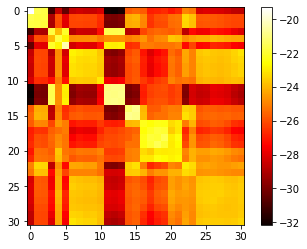

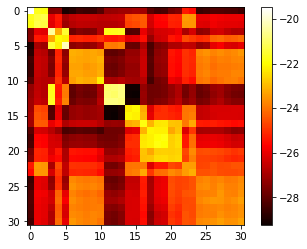

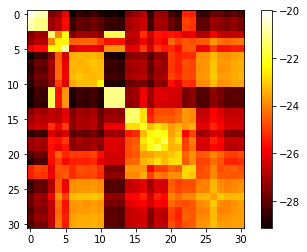

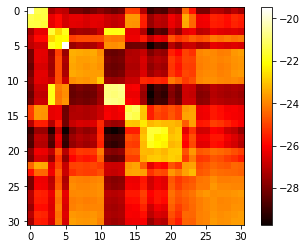

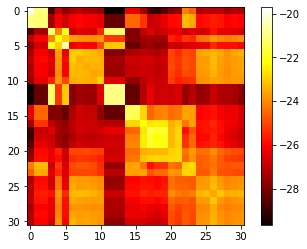

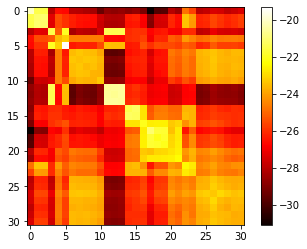

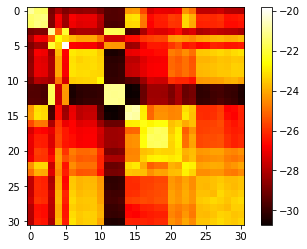

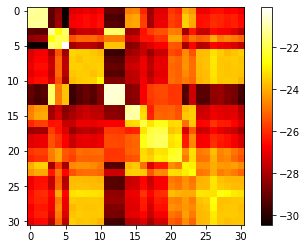

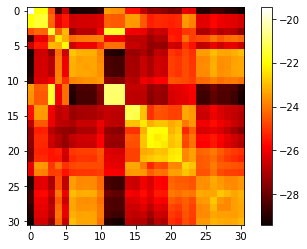

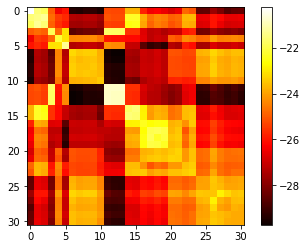

IndexError: index 10 is out of bounds for dimension 0 with size 10

In [21]:
for i in range(10):
    show_heat_map(test_pred[i,:,:].cpu().detach().numpy())

In [20]:
#save the model
torch.save(model, "models/draft_2l_GCN2wn.pkl")

## Some testing and debugging functions

In [ ]:
def fcn(in_features, u):
        norm_u = (u - torch.mean(u, dim=2, keepdim=True))
        print(norm_u)
        print(((1/(in_features-1)) * torch.sum(norm_u**2, dim = 2, keepdim = True))**(1/2))
        return norm_u/(((1/(in_features-1)) * torch.sum(norm_u**2, dim = 2, keepdim = True))**(1/2))


A = torch.tensor([[[1, -1, 3], [2, -2, 1]],[[2, -1, 1], [3, -2, 1]]]).float()
print(A, A.shape)
print(fcn(3, A))

In [ ]:
def forward(sim_matrix, A):
        A_tf = (A!=0)
        print("A_tf:", A_tf)
        abs_N = torch.sum(A_tf, dim = 1, keepdim = True)
        print("abs_N:", abs_N)
        logexp_S = torch.log(torch.sum(torch.exp(sim_matrix), dim = 2, keepdim = True))
        print(logexp_S)
        obj_matrix = A_tf*(sim_matrix - abs_N * logexp_S)
        print(obj_matrix)
        return -torch.sum(obj_matrix)

sim_matrix = torch.tensor([[[1, -1, 3], [2, -2, 1],[1, 2, 3]],[[2, -1, 1], [3, -2, 1],[2, -1, 1]]]).float()
print(sim_matrix)
A = torch.tensor([[0.1,0,0.5],[0,0.7,0],[0.1,0,0.5]])
print(A)

print(forward(sim_matrix, A))

In [ ]:
z = torch.tensor([[[1, -1, 3], [2, -2, 1],[1, 2, 3]],[[2, -1, 1], [3, -2, 1],[2, -1, 1]]]).float()
print(torch.reshape(z[:,1,:], (z.shape[0],1,z.shape[2])))

In [ ]:
weight = torch.tensor([[1],[1],[2]])
print(weight.shape, torch.diag(torch.squeeze(weight)), torch.diag(weight).shape)

In [ ]:
for x in range(1000):
    print(x, end='\r')
print()